## Importamos las bibliotecas a usar

In [1]:
import kagglehub
from PIL import Image, ImageOps, ImageChops, ImageEnhance
from itertools import islice
import glob
import matplotlib.pyplot as plt
import random

<br>
<br>

# Descargamos Dataset

#### Creamos Lista con las rutas a todas las imagenes

En este caso tenemos las imagenes de $29$ peronas, y $13$ selfies
de cada una de estas, por lo que tendremos $377$ imagenes en total.

In [2]:
path = kagglehub.dataset_download("tapakah68/selfies-id-images-dataset")
print("Path to dataset files:", path)

# Solo usamos las selfies
IMAGE_FILES = glob.glob(path + "/**/Selfie*.jpg", recursive=True)
print('Numero de imagenes:', len(IMAGE_FILES))

Path to dataset files: /home/israncho/.cache/kagglehub/datasets/tapakah68/selfies-id-images-dataset/versions/5
Numero de imagenes: 377


<br>
<br>

La mayoria de los las imagenes tienen buena resolucion $2300 \times 3088$ pixeles, 
aunque no todos tiene las mismas dimensiones, y ademas son demasiado grandes para los fines
de este proyecto, razones por las cuales les realizaremos una reduccion de escala.

**Si se requiere ver el tamaño real de la imagen se debe descomentar la linea**

```python
#plt.figure(figsize=(width / DPI, height / DPI))
````

ruta del archivo:
 /home/israncho/.cache/kagglehub/datasets/tapakah68/selfies-id-images-dataset/versions/5/Selfies ID Images dataset/11_sets_Hispanics/0001cc1e1e--61af86f374501f072edf6d2c_age_22_name_Juliana/Selfie_11.jpg
Dimensiones: 2320 , 3088


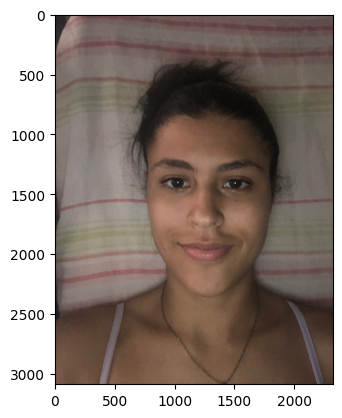

In [3]:
# Abrir la primera imagen
image = ImageOps.exif_transpose(Image.open(IMAGE_FILES[0]))
print('ruta del archivo:\n', IMAGE_FILES[0])
DPI = 96 # pixeles por pulgada
width, height = image.size
#plt.figure(figsize=(width / DPI, height / DPI))  # PARA VER EL TAMA~NO REAL hay que descomentar esta linea <--------------------------------------------
plt.imshow(image)
print('Dimensiones:', width, ',', height)

<br>
<br>

## Reduccion de escala

Si se descomento la linea mencionada se podra ver que en efecto es demasiado grande, por lo que trabajaremos las imagenes con una 
escala reducida, usaremos $\%7$ del tamaño original. 

nuevas dimensiones: 162 , 216


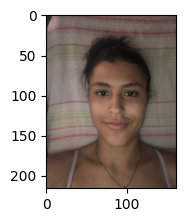

In [4]:
downscaled_width, downscaled_height = int(width * .07) , int(height * .07)
print('nuevas dimensiones:', downscaled_width, ',', downscaled_height)
downscaled_img = image.resize((downscaled_width, downscaled_height))
plt.figure(figsize=(downscaled_width / DPI, downscaled_height / DPI))
plt.imshow(downscaled_img)

<br>
<br>

### Definimos las dimensiones con las cuales se trabajara para el entrenamiento

In [5]:
WIDTH, HEIGHT = downscaled_width, downscaled_height
print('Dimensiones:', WIDTH, 'x', HEIGHT)

Dimensiones: 162 x 216


<br>
<br>

## Creacion del dataset supervisado

Para facilitar la creacion del dataset con supervision primiero organizaremos
la lista con las rutas de las imagenes de una forma distinta.

Podemos notar que si dividimos las cadenas con respecto al caracter `/`
la penultima cadena siempre son los datos de la persona y nos puede
servir como identificador.

In [6]:
IMAGE_FILES[0].split('/')[-2]

'0001cc1e1e--61af86f374501f072edf6d2c_age_22_name_Juliana'

<br>
<br>

**Creamos un diccionario** donde las llaves son el id de la persona
y el valor es el indice de la imagen (en realidad es la ruta absoluta
en el sistema) dentro de

```python
IMAGE_FILES
```


In [7]:
def organized_dataset(image_files: list[str]) -> dict:
    dataset = {}
    for i, image_full_path in enumerate(image_files):
        split_path = image_full_path.split('/')
        person_id = split_path[-2]
        img_type = split_path[-1].split('_')[0]
        if person_id not in dataset:
            dataset[person_id] = {}
        if img_type not in dataset[person_id]:
            dataset[person_id][img_type] = []
            
        dataset[person_id][img_type].append(i)
    return dataset
    
DATASET = organized_dataset(IMAGE_FILES)
print('Personas:', len(DATASET))
print()
dict_key = IMAGE_FILES[0].split('/')[-2]
print('llave del diccionario:', dict_key)
print('valor de la llave anterior:', DATASET[dict_key])

Personas: 29

llave del diccionario: 0001cc1e1e--61af86f374501f072edf6d2c_age_22_name_Juliana
valor de la llave anterior: {'Selfie': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}


In [8]:
def supervised_dataset(dataset: dict, image_types: list[str]) -> tuple[list, list]:
    supervised_ds = []
    all_ids = set(dataset.keys())

    fst_type, *_ = image_types
    
    for person_id in dataset.keys():
        # calculando los pares de la misma persona
        all_img_indexes = [] # lista de todas las imagenes incluyendo varios tipos
        
        for img_type in image_types:
            all_img_indexes.extend(dataset[person_id][img_type])
            
        for img_j in all_img_indexes:
            for img_k in all_img_indexes:
                supervised_ds.append((img_j, img_k, 1))


        # Solo se compara el primer tipo de imagenes
        # Calculando pares de diferentes personas
        all_ids.remove(person_id) # Temporalmente quitamos para comparar solo con otras personas
        for img_i in dataset[person_id][fst_type]:
            for other_person_id in all_ids:
                mismatched_img = list(map(lambda x: (img_i, x, 0), dataset[other_person_id][fst_type]))
                supervised_ds.extend(mismatched_img)
        all_ids.add(person_id) # agregamos para que tambien se comparen con esta

    return supervised_ds
    
SUPERVISED_DATASET = supervised_dataset(DATASET, ['Selfie'])
print(len(SUPERVISED_DATASET))

142129


In [9]:
CLASS0 = list(filter(lambda x: x[2] == 0 , SUPERVISED_DATASET))
CLASS1 = list(filter(lambda x: x[2] == 1 , SUPERVISED_DATASET))
print('Algunos datos de la clase 0:', CLASS0[:10])
print('Algunos datos de la clase 1:', CLASS1[:10])

Algunos datos de la clase 0: [(0, 169, 0), (0, 170, 0), (0, 171, 0), (0, 172, 0), (0, 173, 0), (0, 174, 0), (0, 175, 0), (0, 176, 0), (0, 177, 0), (0, 178, 0)]
Algunos datos de la clase 1: [(0, 0, 1), (0, 1, 1), (0, 2, 1), (0, 3, 1), (0, 4, 1), (0, 5, 1), (0, 6, 1), (0, 7, 1), (0, 8, 1), (0, 9, 1)]


In [10]:
def show_imgs_side_to_side(img1, img2):
    fig, axes = plt.subplots(1, 2)
    
    axes[0].imshow(img1)
    axes[0].axis('off')  # Desactivar los ejes
    axes[0].set_title("Imagen 1")
    
    axes[1].imshow(img2)
    axes[1].axis('off')  # Desactivar los ejes
    axes[1].set_title("Imagen 2")
    
    plt.tight_layout()
    plt.show()


<br>
<br>

### Ejemplo de dato de entrenamiento aleatorio de la clase 0 sin reducir

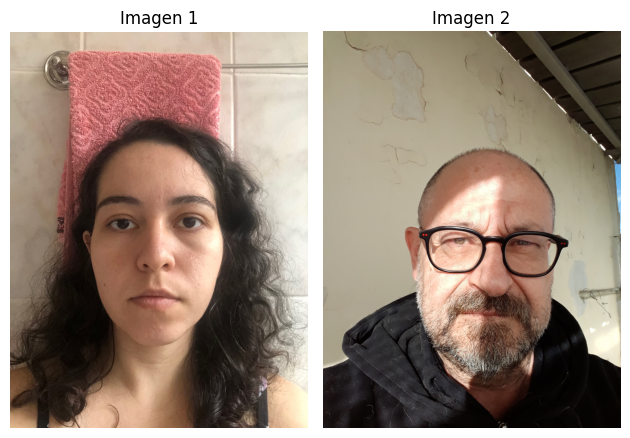

In [11]:
fst_img_i, snd_img_i, _ = random.choice(CLASS0)
fst_img_file, snd_img_file = IMAGE_FILES[fst_img_i], IMAGE_FILES[snd_img_i]
fst_img, snd_img = ImageOps.exif_transpose(Image.open(fst_img_file)), ImageOps.exif_transpose(Image.open(snd_img_file))
show_imgs_side_to_side(fst_img, snd_img)

<br>
<br>

### Ejemplo de dato de entrenamiento aleatorio de la clase 1 sin reducir

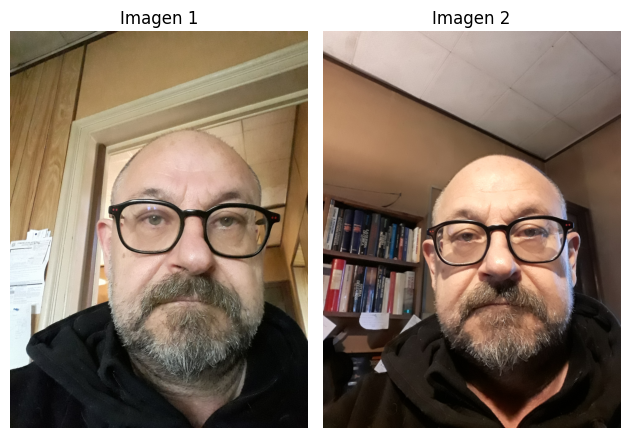

In [12]:
fst_img_i, snd_img_i, _ = random.choice(CLASS1)
fst_img_file, snd_img_file = IMAGE_FILES[fst_img_i], IMAGE_FILES[snd_img_i]
fst_img, snd_img = ImageOps.exif_transpose(Image.open(fst_img_file)), ImageOps.exif_transpose(Image.open(snd_img_file))
show_imgs_side_to_side(fst_img, snd_img)

<br>
<br>
<br>

## Desbalanceo de datos
### La cantidad de datos para cada clase esta muy desbalanceado
### La cantidad de datos para la clase 1 es muy peque~na

In [13]:
print('Datos de la clase 0:', len(CLASS0))
print('Datos de la clase 1:', len(CLASS1))

Datos de la clase 0: 137228
Datos de la clase 1: 4901


<br>
<br>

### Trabajaremos con transformaciones para crear mas datos de la clase 1

In [14]:
def translate_image(image, x_offset, y_offset):
    return ImageChops.offset(image, x_offset, y_offset)

def rotate_image(image, angle):
    return image.rotate(angle, resample=Image.BICUBIC, expand=True)

def adjust_brightness(image, factor):
    enhancer = ImageEnhance.Brightness(image)
    return enhancer.enhance(factor)

def zoom_image(image, zoom_factor):
    assert zoom_factor > 0, 'zoom factor must be greater than 0.'
    
    width, height = image.size
    crop_width = int(width / zoom_factor)
    crop_height = int(height / zoom_factor)

    # Definir los bordes para recortar el centro
    left = (width - crop_width) // 2
    top = (height - crop_height) // 2
    right = left + crop_width
    bottom = top + crop_height

    # Recortar y escalar
    cropped_image = image.crop((left, top, right, bottom))
    return cropped_image.resize((width, height), Image.Resampling.LANCZOS)

<br>
<br>

### Pruebas de la misma imagen pero transformada

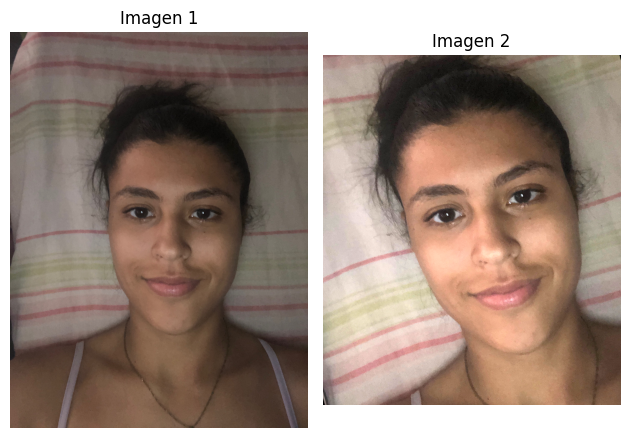

In [15]:
trasnformed_img = zoom_image(rotate_image(adjust_brightness(translate_image(image, 10, 10), 1.5), 15), 1.65)
show_imgs_side_to_side(image, trasnformed_img)

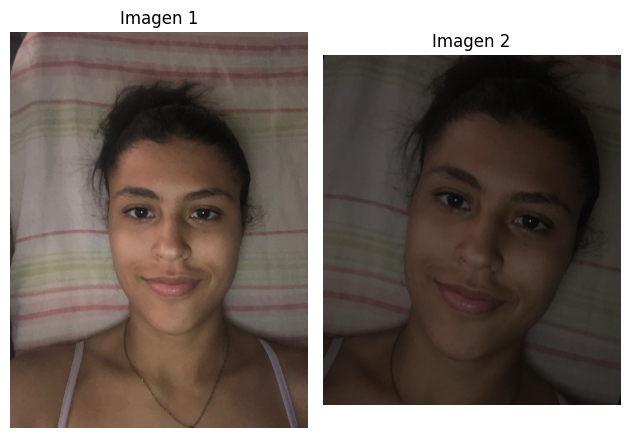

In [16]:
trasnformed_img2 = zoom_image(rotate_image(adjust_brightness(translate_image(image, -10, -10), 0.5), -15), 1.65)
show_imgs_side_to_side(image, trasnformed_img2)

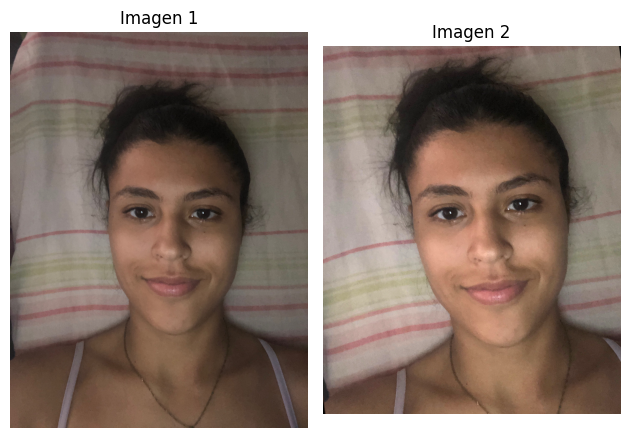

In [17]:
trasnformed_img3 = zoom_image(rotate_image(adjust_brightness(translate_image(image, 5, 5), 1.25), 8), 1.35)
show_imgs_side_to_side(image, trasnformed_img3)

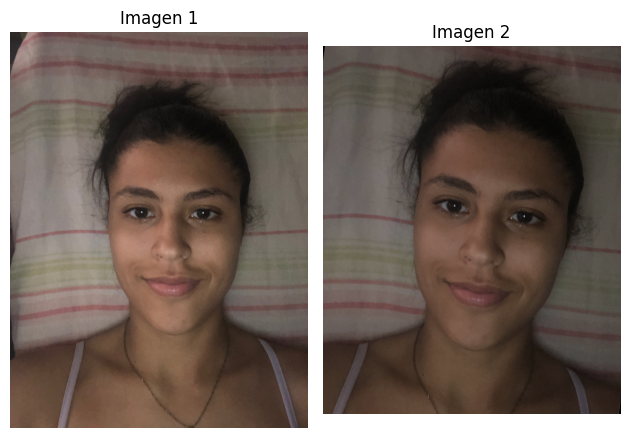

In [18]:
trasnformed_img4 = zoom_image(rotate_image(adjust_brightness(translate_image(image, -5, -5), 0.75), -8), 1.35)
show_imgs_side_to_side(image, trasnformed_img4)

In [19]:
def augment_dataset(image_files: list[str]) -> None:
    for image_full_path in image_files:
        split_path = image_full_path.split('/')
        file_name = split_path[-1]
        img = ImageOps.exif_transpose(Image.open(image_full_path))
        
        t_img1 = zoom_image(rotate_image(adjust_brightness(translate_image(img, 10, 10), 1.5), 15), 1.65)
        split_path[-1] = 'transformed_1_' + file_name
        t_img1.save('/'.join(split_path))
        
        t_img2 = zoom_image(rotate_image(adjust_brightness(translate_image(img, -10, -10), 0.5), -15), 1.65)
        split_path[-1] = 'transformed_2_' + file_name
        t_img2.save('/'.join(split_path))
        
        t_img3 = zoom_image(rotate_image(adjust_brightness(translate_image(img, 5, 5), 1.25), 8), 1.35)
        split_path[-1] = 'transformed_3_' + file_name
        t_img3.save('/'.join(split_path))
        
        t_img4 = zoom_image(rotate_image(adjust_brightness(translate_image(img, -5, -5), 0.75), -8), 1.35)
        split_path[-1] = 'transformed_4_' + file_name
        t_img4.save('/'.join(split_path))


flag_file = "already_executed.flag"

try:
    # Intentamos abrir el archivo en modo lectura
    with open(flag_file, "r") as f:
        print("Ya se han generado las imagenes transformadas, no se generaran nuevamente")
except FileNotFoundError:
    # Si el archivo no existe, ejecutamos el código
    augment_dataset(IMAGE_FILES)
    with open(flag_file, "w") as f:
        f.write("Imagenes generadas")
    print('Se han generado las imagenes')


Ya se han generado las imagenes transformadas, no se generaran nuevamente


In [20]:
TRANSFORMED_IMAGE_FILES = glob.glob(path + "/**/transformed_*_Selfie*.jpg", recursive=True)
print(TRANSFORMED_IMAGE_FILES[0].split('/')[-1])

transformed_4_Selfie_1.jpg


<br>
<br>
<br>
<br>

# Creamos el dataset con cantidades balanceadas de datos para cada clase

In [21]:
ALL_PATHS_TO_IMAGE_FILES = IMAGE_FILES + TRANSFORMED_IMAGE_FILES
print('Cantidad total de imagenes:',len(ALL_PATHS_TO_IMAGE_FILES))

Cantidad total de imagenes: 1885


In [22]:
DATASET = None
DATASET = organized_dataset(ALL_PATHS_TO_IMAGE_FILES)
print('Personas:', len(DATASET))
print()
dict_key = ALL_PATHS_TO_IMAGE_FILES[0].split('/')[-2]
print('llave del diccionario:', dict_key)
print('valor de la llave anterior:', DATASET[dict_key])

Personas: 29

llave del diccionario: 0001cc1e1e--61af86f374501f072edf6d2c_age_22_name_Juliana
valor de la llave anterior: {'Selfie': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'transformed': [377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428]}


In [23]:
SUPERVISED_DATASET = None
SUPERVISED_DATASET = supervised_dataset(DATASET, ['Selfie', 'transformed'])
print('tama~no del dataset supervisado:', len(SUPERVISED_DATASET))
CLASS0 = list(filter(lambda x: x[2] == 0 , SUPERVISED_DATASET))
CLASS1 = list(filter(lambda x: x[2] == 1 , SUPERVISED_DATASET))
print('Datos de la clase 0:', len(CLASS0))
print('Datos de la clase 1:', len(CLASS1))

tama~no del dataset supervisado: 259753
Datos de la clase 0: 137228
Datos de la clase 1: 122525


<br>
<br>

## Dataset supervisado listo para usarse, esta guardado de la siguiente forma

```python
SUPERVISED_DATASET
```

## Funcion para obtener una imagen con el formato usado para entrenar

```python
get_image(index_of_img)
```
Se usa el indice que se tiene en 

```python
ALL_PATHS_TO_IMAGE_FILES
```

In [24]:
def get_image(index_of_img: int):
    return ImageOps.exif_transpose(Image.open(ALL_PATHS_TO_IMAGE_FILES[index_of_img])).resize((WIDTH, HEIGHT))

### Ejemplos de imagenes de la clase 0

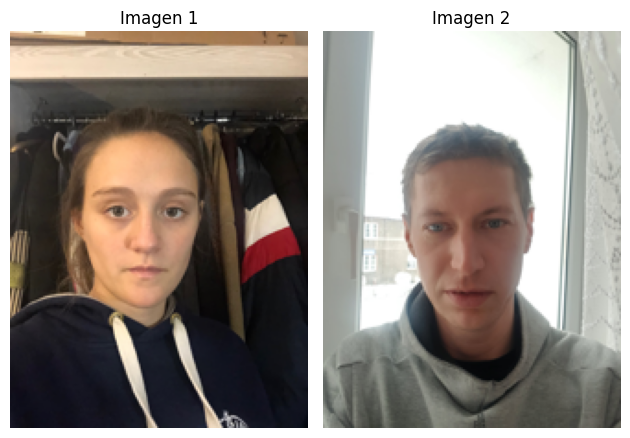

In [25]:
fst_img_index, snd_img_index, class_number = random.choice(CLASS0)
show_imgs_side_to_side(get_image(fst_img_index), get_image(snd_img_index))

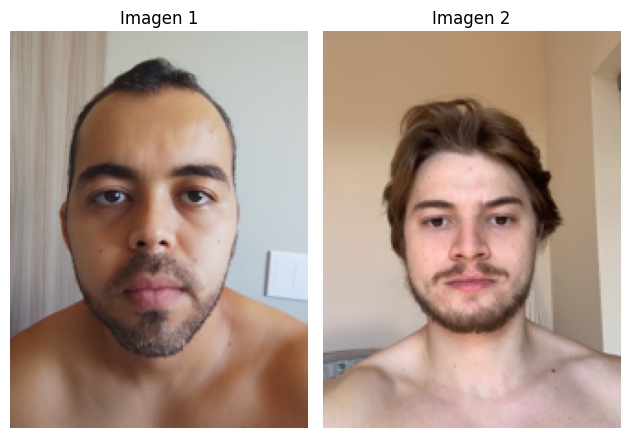

In [26]:
fst_img_index, snd_img_index, class_number = random.choice(CLASS0)
show_imgs_side_to_side(get_image(fst_img_index), get_image(snd_img_index))

### Ejemplos de imagenes de la clase 1

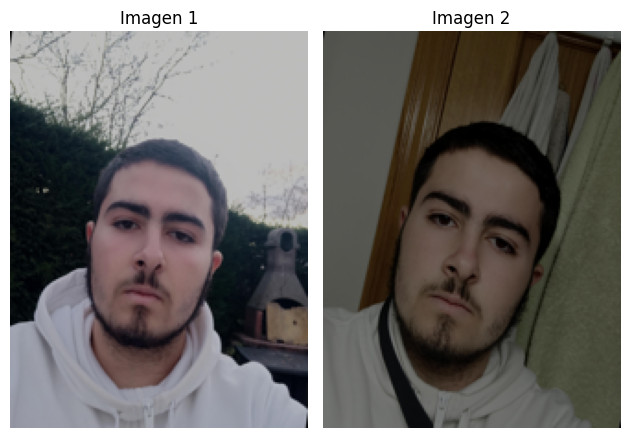

In [27]:
fst_img_index, snd_img_index, class_number = random.choice(CLASS1)
show_imgs_side_to_side(get_image(fst_img_index), get_image(snd_img_index))

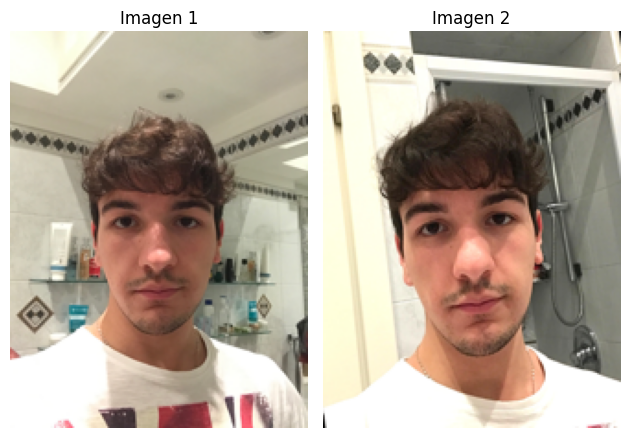

In [28]:
fst_img_index, snd_img_index, class_number = random.choice(CLASS1)
show_imgs_side_to_side(get_image(fst_img_index), get_image(snd_img_index))